<a href="https://colab.research.google.com/github/Fatai-soliu/Text-Classification/blob/main/Soliu_Fatai_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [8]:
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             cohen_kappa_score, matthews_corrcoef, classification_report)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [9]:
# Read the file from my personal Github repository where it was hosted

url = 'https://github.com/Fatai-soliu/Text-Classification/raw/master/Scopusdataset.xlsx'

papers = pd.read_excel(url, engine='openpyxl')

In [10]:
# Get datapoints in the dataset

datapoints = len(papers)

print('Number of datapoints:', datapoints)

Number of datapoints: 4357


In [11]:
#Assign Label

#def assign_label(subject):
   # if subject == "Business":
       # return 0
  #  elif subject == "Computer science and engineering":
       # return 1
   # elif subject == "Mathematics":
   #     return 2
  #  else:
      #  return None  # Handle other cases if needed

# Apply the function to your DataFrame
#papers["label"] = papers["Subject"].apply(assign_label)


papers.tail()

,Abstract,Subject
4352,Observation of human actions influences the ob...,Arts and Humanities
4353,Confidentiality presents particular challenges...,Arts and Humanities
4354,One of the new factors in Eastern European cou...,Arts and Humanities
4355,In this paper we present our experiences of co...,Arts and Humanities
4356,This paper concerns changes in the spatial str...,Arts and Humanities


In [12]:
# Drop Subject column

#papers = papers.drop(columns=['Subject'], axis=1)

#print out the first five rows of papers
papers.head()

,Abstract,Subject
0,This study aims to investigate the potential r...,Medicine
1,Background: Childhood adversity can have lasti...,Medicine
2,Eccentric resistance training has been shown t...,Medicine
3,"In the post-COVID city, interest in creative g...",Medicine
4,Purpose: Recent research has proposed a specif...,Medicine


In [13]:
# Check if there is any missing data

papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357 entries, 0 to 4356
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Abstract  4357 non-null   object
 1   Subject   4357 non-null   object
dtypes: object(2)
memory usage: 68.2+ KB


# **Text preprocesssing**

In [14]:
#Import neccessary libraries for text preprocessing

import re
from string import punctuation

In [15]:
!pip install contractions
import contractions

In [16]:
#Create a function for preprocessing

def clean_text(text):
    # make text lowercase
    text = str(text).lower()
    text = re.sub(r"[’‘']", "", text)
    # expand contractions
    text = " ".join([contractions.fix(expanded_word) for expanded_word in text.split()])
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    text = re.sub(r"[’']", "", text)
    # remove new lines
    text = re.sub('\n', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # remove apostrophes
    text = re.sub("''", '', text)
    return text

In [17]:
# apply function on each text in the dataset

papers['clean_Abstract'] = papers['Abstract'].apply(lambda x: clean_text(x))

papers.head(10)

,Abstract,Subject,clean_Abstract
0,This study aims to investigate the potential r...,Medicine,this study aims to investigate the potential r...
1,Background: Childhood adversity can have lasti...,Medicine,background childhood adversity can have lastin...
2,Eccentric resistance training has been shown t...,Medicine,eccentric resistance training has been shown t...
3,"In the post-COVID city, interest in creative g...",Medicine,in the postcovid city interest in creative gre...
4,Purpose: Recent research has proposed a specif...,Medicine,purpose recent research has proposed a specifi...
5,Background: The cost of losing foot health is ...,Medicine,background the cost of losing foot health is s...
6,"Microdosing, in the context of resistance trai...",Medicine,microdosing in the context of resistance train...
7,Objectives: This research aimed to identify th...,Medicine,objectives this research aimed to identify the...
8,Objective: The aim of the study was to establi...,Medicine,objective the aim of the study was to establis...
9,Background: Depression is common in people wit...,Medicine,background depression is common in people with...


Tokenization

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
from nltk.tokenize import word_tokenize

papers['Abstract_words'] = papers['clean_Abstract'].apply(lambda x:word_tokenize(str(x)))
papers.head(10)

,Abstract,Subject,clean_Abstract,Abstract_words
0,This study aims to investigate the potential r...,Medicine,this study aims to investigate the potential r...,"[this, study, aims, to, investigate, the, pote..."
1,Background: Childhood adversity can have lasti...,Medicine,background childhood adversity can have lastin...,"[background, childhood, adversity, can, have, ..."
2,Eccentric resistance training has been shown t...,Medicine,eccentric resistance training has been shown t...,"[eccentric, resistance, training, has, been, s..."
3,"In the post-COVID city, interest in creative g...",Medicine,in the postcovid city interest in creative gre...,"[in, the, postcovid, city, interest, in, creat..."
4,Purpose: Recent research has proposed a specif...,Medicine,purpose recent research has proposed a specifi...,"[purpose, recent, research, has, proposed, a, ..."
5,Background: The cost of losing foot health is ...,Medicine,background the cost of losing foot health is s...,"[background, the, cost, of, losing, foot, heal..."
6,"Microdosing, in the context of resistance trai...",Medicine,microdosing in the context of resistance train...,"[microdosing, in, the, context, of, resistance..."
7,Objectives: This research aimed to identify th...,Medicine,objectives this research aimed to identify the...,"[objectives, this, research, aimed, to, identi..."
8,Objective: The aim of the study was to establi...,Medicine,objective the aim of the study was to establis...,"[objective, the, aim, of, the, study, was, to,..."
9,Background: Depression is common in people wit...,Medicine,background depression is common in people with...,"[background, depression, is, common, in, peopl..."


Stop words removal

In [20]:
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# define stopword removal function
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're',"in", "'",'used','using','one','two','also','use','us','may','ai','ad','data','research','study','research','method','process','paper'])

def remove_stopword(word_list):
    return ' '.join([word for word in word_list if word not in stop_words])

papers['Abstract_words_excl_sw'] = papers['Abstract_words'].apply(remove_stopword)

In [22]:
papers.head(10)

,Abstract,Subject,clean_Abstract,Abstract_words,Abstract_words_excl_sw
0,This study aims to investigate the potential r...,Medicine,this study aims to investigate the potential r...,"[this, study, aims, to, investigate, the, pote...",aims investigate potential risk contamination ...
1,Background: Childhood adversity can have lasti...,Medicine,background childhood adversity can have lastin...,"[background, childhood, adversity, can, have, ...",background childhood adversity lasting negativ...
2,Eccentric resistance training has been shown t...,Medicine,eccentric resistance training has been shown t...,"[eccentric, resistance, training, has, been, s...",eccentric resistance training shown elicit ben...
3,"In the post-COVID city, interest in creative g...",Medicine,in the postcovid city interest in creative gre...,"[in, the, postcovid, city, interest, in, creat...",postcovid city interest creative green interve...
4,Purpose: Recent research has proposed a specif...,Medicine,purpose recent research has proposed a specifi...,"[purpose, recent, research, has, proposed, a, ...",purpose recent proposed specific female phenot...
5,Background: The cost of losing foot health is ...,Medicine,background the cost of losing foot health is s...,"[background, the, cost, of, losing, foot, heal...",background cost losing foot health significant...
6,"Microdosing, in the context of resistance trai...",Medicine,microdosing in the context of resistance train...,"[microdosing, in, the, context, of, resistance...",microdosing context resistance training increa...
7,Objectives: This research aimed to identify th...,Medicine,objectives this research aimed to identify the...,"[objectives, this, research, aimed, to, identi...",objectives aimed identify characteristics stro...
8,Objective: The aim of the study was to establi...,Medicine,objective the aim of the study was to establis...,"[objective, the, aim, of, the, study, was, to,...",objective aim establish whether rheumatoid art...
9,Background: Depression is common in people wit...,Medicine,background depression is common in people with...,"[background, depression, is, common, in, peopl...",background depression common people chronic ki...


In [23]:
# Create a list for each Subject

Medicine = papers[papers['Subject']== 'Medicine']['Abstract_words_excl_sw']
Arts_and_Humanities = papers[papers['Subject']== 'Arts and Humanities']['Abstract_words_excl_sw']
Business_management = papers[papers['Subject']== 'Business management']['Abstract_words_excl_sw']

Medicine.head()

0    aims investigate potential risk contamination ...
1    background childhood adversity lasting negativ...
2    eccentric resistance training shown elicit ben...
3    postcovid city interest creative green interve...
4    purpose recent proposed specific female phenot...
Name: Abstract_words_excl_sw, dtype: object

In [24]:
def word_cloud(data, title, background_color="black", max_words = 50, cotour_width=3, contour_color='steelblue', width=200, height=100):
  long_string = ','.join(str(l) for l in data)

  wordcloud = WordCloud(background_color=background_color,
                        max_words=max_words,
                        contour_width=cotour_width,
                        contour_color=contour_color,
                        width=width,
                        height=height,
                        scale=2,
                        collocations=False)
  wordcloud.generate(long_string)

  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')
  plt.show()

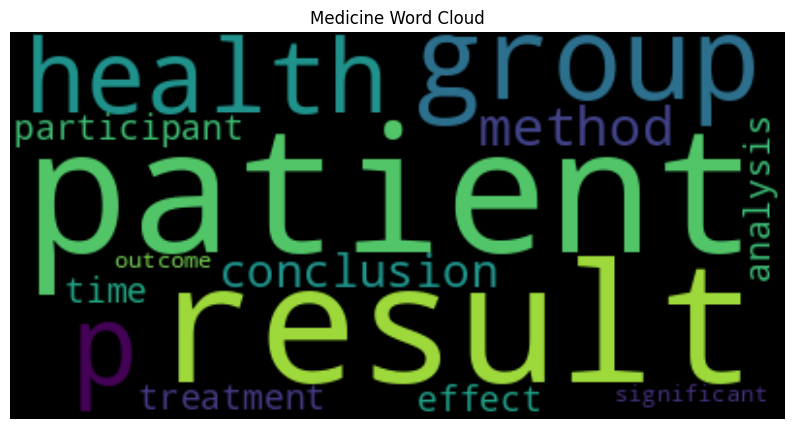

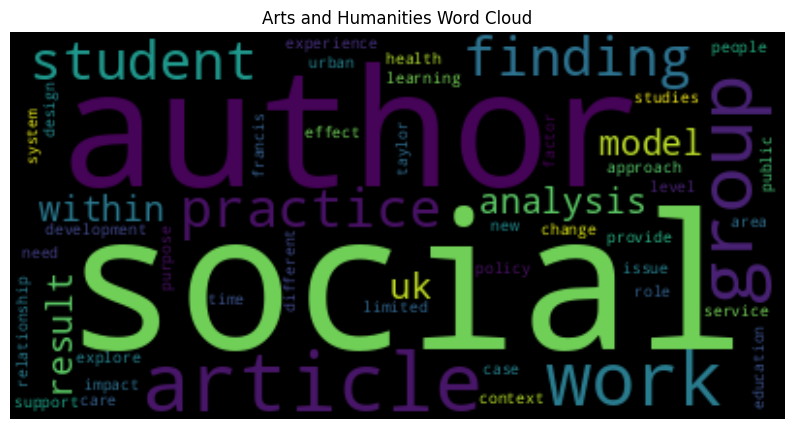

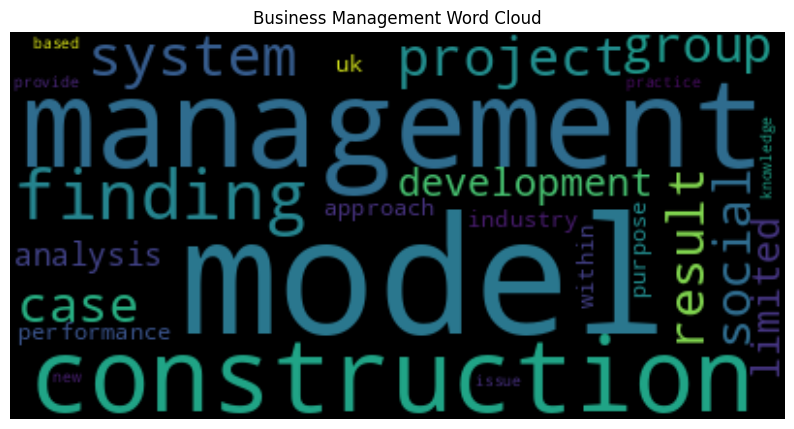

In [25]:
# Visualize wordcloud

word_cloud(Medicine, "Medicine Word Cloud")
word_cloud(Arts_and_Humanities, "Arts and Humanities Word Cloud")
word_cloud(Business_management, "Business Management Word Cloud")

Text(0.5, 9.444444444444438, 'The number of words')

<Figure size 800x1000 with 0 Axes>

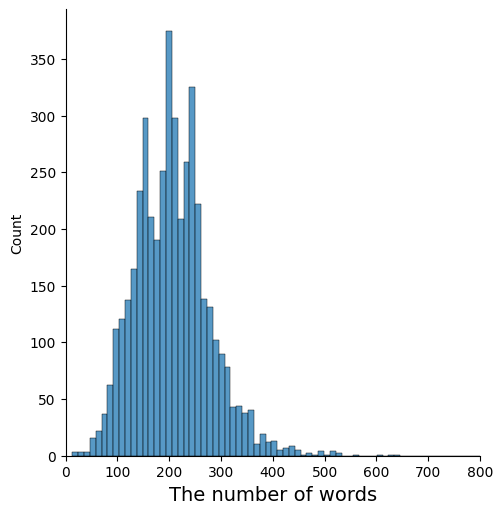

In [26]:
# Number of words per sentence

count_sent_word = [len(sentence) for sentence in papers['Abstract_words']]

plt.figure(figsize=(8, 10))

sns.displot(count_sent_word)

plt.xlim(0, 800)

plt.xlabel("The number of words", fontsize=14)

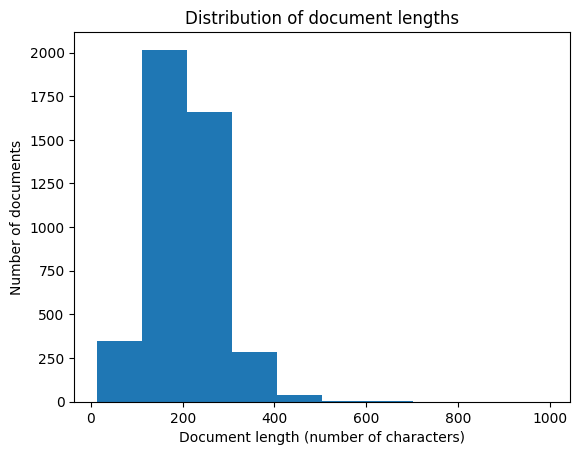

In [27]:
#length of text document

document_lengths = [len(doc) for doc in papers['Abstract_words']]

# Plot a histogram of document lengths
plt.hist(document_lengths)
plt.xlabel("Document length (number of characters)")
plt.ylabel("Number of documents")
plt.title("Distribution of document lengths")
plt.show()

In [28]:
# Encoding the Subject
encoder = LabelEncoder()
category_encode = encoder.fit_transform(papers['Subject'])
num_classes = len(encoder.classes_)



# Print the mapping of categories to their encoded values
print('Category encoding mapping:')
for category, code in zip(encoder.classes_, encoder.transform(encoder.classes_)):
    print(f'{category}: {code}')

Category encoding mapping:
Arts and Humanities: 0
Business management: 1
Medicine: 2


Lemmatization

After removing stopwords, I applied lemmatization technique to further preprocces the text data by converting each word to its base form

In [29]:
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

#lemmatizer = WordNetLemmatizer()
#papers['Abstract_words_excl_sw'] = papers['Abstract_words_excl_sw'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
#papers.tail()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
#papers = papers.drop(columns=['Abstract','clean_Abstract','Abstract_words'], axis=1)

#print out the first five rows of papers
papers.head()

,Abstract,Subject,clean_Abstract,Abstract_words,Abstract_words_excl_sw
0,This study aims to investigate the potential r...,Medicine,this study aims to investigate the potential r...,"[this, study, aims, to, investigate, the, pote...",aims investigate potential risk contamination ...
1,Background: Childhood adversity can have lasti...,Medicine,background childhood adversity can have lastin...,"[background, childhood, adversity, can, have, ...",background childhood adversity lasting negativ...
2,Eccentric resistance training has been shown t...,Medicine,eccentric resistance training has been shown t...,"[eccentric, resistance, training, has, been, s...",eccentric resistance training shown elicit ben...
3,"In the post-COVID city, interest in creative g...",Medicine,in the postcovid city interest in creative gre...,"[in, the, postcovid, city, interest, in, creat...",postcovid city interest creative green interve...
4,Purpose: Recent research has proposed a specif...,Medicine,purpose recent research has proposed a specifi...,"[purpose, recent, research, has, proposed, a, ...",purpose recent proposed specific female phenot...


# **Train and Test Split**

In [31]:
Abstract = papers.Abstract_words_excl_sw

print(Abstract)

0       aims investigate potential risk contamination ...
1       background childhood adversity lasting negativ...
2       eccentric resistance training shown elicit ben...
3       postcovid city interest creative green interve...
4       purpose recent proposed specific female phenot...
                              ...                        
4352    observation human actions influences observers...
4353    confidentiality presents particular challenges...
4354    new factors eastern european countries acknowl...
4355    present experiences conducting focus groups yo...
4356    concerns changes spatial structure british pub...
Name: Abstract_words_excl_sw, Length: 4357, dtype: object


In [32]:
Abstract = papers.Abstract_words_excl_sw


print(Abstract)

0       aims investigate potential risk contamination ...
1       background childhood adversity lasting negativ...
2       eccentric resistance training shown elicit ben...
3       postcovid city interest creative green interve...
4       purpose recent proposed specific female phenot...
                              ...                        
4352    observation human actions influences observers...
4353    confidentiality presents particular challenges...
4354    new factors eastern european countries acknowl...
4355    present experiences conducting focus groups yo...
4356    concerns changes spatial structure british pub...
Name: Abstract_words_excl_sw, Length: 4357, dtype: object


In [33]:
#Data splitting
# 20% of the data will be reserved for testing and 10% for validation

X_train, X_temp, y_train, y_temp = train_test_split(Abstract, category_encode, test_size=0.3, random_state=40)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

In [34]:
X_train[:3]

1024    background purpose performance mammography scr...
1804    background aim case analyze effect gait parame...
4356    concerns changes spatial structure british pub...
Name: Abstract_words_excl_sw, dtype: object

In [35]:
X_temp[:3]

3693    purpose personality disorder reported elicit s...
624     mobile mental health presents many ethical cha...
3199    last years british labour history frequent exa...
Name: Abstract_words_excl_sw, dtype: object

In [36]:
X_train,X_test,y_train,y_temp

(1024    background purpose performance mammography scr...
 1804    background aim case analyze effect gait parame...
 4356    concerns changes spatial structure british pub...
 1857    purpose aims provide commentary previous issue...
 2384    purpose present different issues facing proble...
                               ...                        
 2103    range management accounting innovations mais e...
 3603    explores political dimensions place branding p...
 3340    academic valuable transactional analysis provi...
 3064    vr application designed mobile phones combinin...
 3398    article uses interwar wartime career anthony e...
 Name: Abstract_words_excl_sw, Length: 3049, dtype: object,
 3141    children scotland experiencing parents impriso...
 2171    purpose – aims explain voter perceptions votin...
 2335    explosion industrial political militancy swept...
 2731    writing organizations assumes everyone sensibl...
 2972    existing workplace bullying literature suggest

In [37]:
#Convert train, train, validation set into numpy array for model training

X_train_nnlm = np.array(X_train)
X_val_nnlm = np.array(X_val)
X_test_nnlm = np.array(X_test)

# **Biuld Model**

In [38]:
num_classes = len(encoder.classes_)

# Model 1 is nnlm-en-dim50

In [67]:
# model 1 is nnlm-en-dim50

model_1 = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model_1, input_shape=[], dtype=tf.string, trainable=True)
#hub_layer(X_train_nnlm)

In [68]:
# Define model architecture

model_1 = tf.keras.Sequential()
model_1.add(hub_layer)
model_1.add(tf.keras.layers.Dense(256, activation='relu'))
model_1.add(tf.keras.layers.Dense(128, activation='relu'))
model_1.add(tf.keras.layers.Dense(64, activation='relu'))
model_1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_9 (Dense)             (None, 256)               13056     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 3)                 195       
                                                                 
Total params: 48245003 (184.04 MB)
Trainable params: 48245003 (184.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
# compile the model and specify learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate = learning_rate)

model_1.compile(optimizer=optimizer,
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
#Specify early stop to save training time and prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2)


history_1 = model_1.fit(X_train_nnlm,
                    y_train,
                    epochs=10,
                    batch_size=20,
                    validation_data=(X_val_nnlm, y_val),
                    verbose=1, callbacks=[early_stop])


#For evaluation and performance metrics, convert numpy back to base form
X_test = X_test_nnlm
y_test = y_test

# Model 2 is nnlm-en-dim50-with-normalization

In [43]:
# model 2 is nnlm-en-dim50-with-normalization

model_2 = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(model_2, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train_nnlm)

<tf.Tensor: shape=(3049, 50), dtype=float32, numpy=
array([[-0.10152645, -0.8055029 ,  0.0840074 , ...,  0.15737826,
         1.6296715 ,  0.70976776],
       [ 0.43306795, -0.9830399 ,  0.34142914, ..., -0.2146571 ,
         1.0058516 ,  0.29892555],
       [ 0.15361339, -0.35177255,  0.09602879, ...,  0.14194562,
         1.0775127 ,  0.01651192],
       ...,
       [ 0.13700081, -0.02160605,  0.2820144 , ..., -0.24301043,
         1.0103614 ,  0.32829556],
       [ 0.07167423, -0.30951136,  0.26099938, ..., -0.03348826,
         1.0356065 ,  0.5602326 ],
       [ 0.74028194, -0.30526206, -0.04797801, ...,  0.6576944 ,
         0.841381  ,  0.31476906]], dtype=float32)>

In [44]:
# Define model architecture

model_2 = tf.keras.Sequential()
model_2.add(hub_layer)
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dense(1))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 64)                3264      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48193929 (183.85 MB)
Trainable params: 48193929 (183.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# compile the model and specify learning rate
learning_rate = 0.01

optimizer = Adam(learning_rate = learning_rate)

model_2.compile(optimizer=optimizer,
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [46]:
#Specify early stop to save training time and prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2)


history_2 = model_2.fit(X_train_nnlm,
                    y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_val_nnlm, y_val),
                    verbose=1, callbacks=[early_stop])


#For evaluation and performance metrics, convert numpy back to base form
X_test = X_test_nnlm
y_test = y_test

Epoch 1/10
12/12 [==============================] - 26s 2s/step - loss: -3.2457 - accuracy: 0.2361 - val_loss: -13.6234 - val_accuracy: 0.2176
Epoch 2/10
12/12 [==============================] - 26s 2s/step - loss: -36.8977 - accuracy: 0.2755 - val_loss: -84.6330 - val_accuracy: 0.2361
Epoch 3/10
12/12 [==============================] - 23s 2s/step - loss: -167.8562 - accuracy: 0.3119 - val_loss: -303.1731 - val_accuracy: 0.2315
Epoch 4/10
12/12 [==============================] - 26s 2s/step - loss: -516.6173 - accuracy: 0.2906 - val_loss: -815.6937 - val_accuracy: 0.2315
Epoch 5/10
12/12 [==============================] - 26s 2s/step - loss: -1271.1814 - accuracy: 0.2988 - val_loss: -1819.2870 - val_accuracy: 0.2269
Epoch 6/10
12/12 [==============================] - 25s 2s/step - loss: -2649.8462 - accuracy: 0.3021 - val_loss: -3562.3860 - val_accuracy: 0.2292
Epoch 7/10
12/12 [==============================] - 27s 2s/step - loss: -4898.3413 - accuracy: 0.2981 - val_loss: -6342.2212 

# Model 3 is nnlm-en-dim128-with-normalization

In [47]:
model_3 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(model_3, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train_nnlm)

<tf.Tensor: shape=(3049, 128), dtype=float32, numpy=
array([[ 0.34029   ,  0.12306307,  0.03680037, ..., -0.37640756,
         0.0765768 , -0.09745757],
       [ 0.06647538,  0.05000653, -0.07722206, ..., -0.3770071 ,
        -0.26192984,  0.19769664],
       [ 0.32439324,  0.5405722 ,  0.2656632 , ..., -0.14007227,
         0.1909886 ,  0.03605372],
       ...,
       [ 0.2955255 ,  0.08317772,  0.06133217, ..., -0.11942005,
         0.00756727, -0.02033661],
       [ 0.16610317,  0.1687876 ,  0.0953819 , ..., -0.03765266,
        -0.05754982,  0.03497611],
       [ 0.18172866,  0.3997092 ,  0.29292268, ..., -0.24713308,
         0.4657989 , -0.3590864 ]], dtype=float32)>

In [48]:
# Define model architecture

model_3 = tf.keras.Sequential()
model_3.add(hub_layer)
model_3.add(tf.keras.layers.Dense(128, activation='relu'))
model_3.add(tf.keras.layers.Dense(64, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124667521 (475.57 MB)
Trainable params: 124667521 (475.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# compile the model and specify learning rate
learning_rate = 0.01

optimizer = Adam(learning_rate = learning_rate)

model_3.compile(optimizer=optimizer,
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [50]:
#Specify early stop to save training time and prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2)


history_3 = model_3.fit(X_train_nnlm,
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_val_nnlm, y_val),
                    verbose=1, callbacks=[early_stop])


#For evaluation and performance metrics, convert numpy back to base form
X_test = X_test_nnlm
y_test = y_test

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


12/12 [==============================] - 70s 6s/step - loss: -45.5458 - accuracy: 0.2279 - val_loss: -262.5517 - val_accuracy: 0.2130
Epoch 2/20
12/12 [==============================] - 91s 7s/step - loss: -1225.9241 - accuracy: 0.2279 - val_loss: -3785.3123 - val_accuracy: 0.2130
Epoch 3/20
12/12 [==============================] - 65s 5s/step - loss: -10451.7363 - accuracy: 0.2293 - val_loss: -23380.5723 - val_accuracy: 0.2245
Epoch 4/20
12/12 [==============================] - 65s 5s/step - loss: -49255.7188 - accuracy: 0.2794 - val_loss: -95749.8359 - val_accuracy: 0.2292
Epoch 5/20
12/12 [==============================] - 49s 4s/step - loss: -176528.3125 - accuracy: 0.2958 - val_loss: -299972.3125 - val_accuracy: 0.2315
Epoch 6/20
12/12 [==============================] - 48s 4s/step - loss: -505598.1250 - accuracy: 0.2870 - val_loss: -778970.4375 - val_accuracy: 0.2292
Epoch 7/20
12/12 [==============================] - 43s 4s/step - loss: -1223451.2500 - accuracy: 0.2909 - val_los

# **Evaluate Model 1**

In [51]:
#result from model_1

results_1 = model_1.evaluate(X_test, y_test)

print(results_1)

28/28 [==============================] - 6s 205ms/step - loss: 0.6003 - accuracy: 0.2215
[0.6002933979034424, 0.2214611917734146]


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

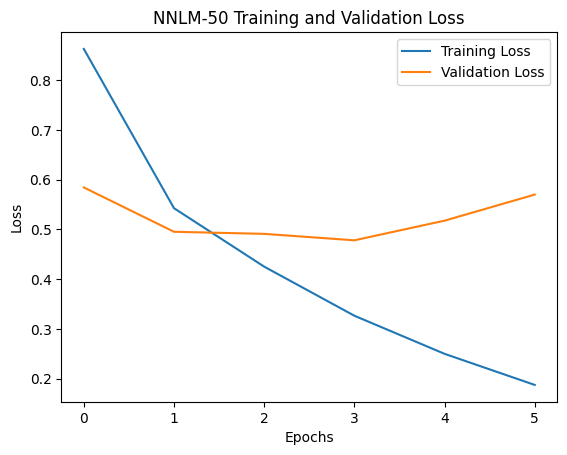

In [57]:
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('NNLM-50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
predictions = model_1.predict(X_val)
y_pred = (predictions > 0.5).astype('int32')

14/14 [==============================] - 5s 356ms/step


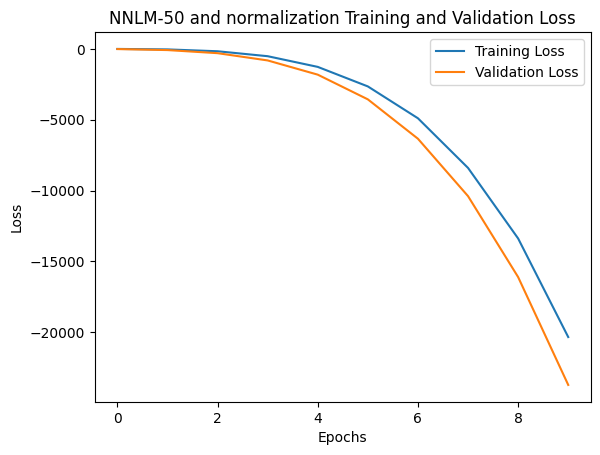

In [73]:
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('NNLM-50 and normalization Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

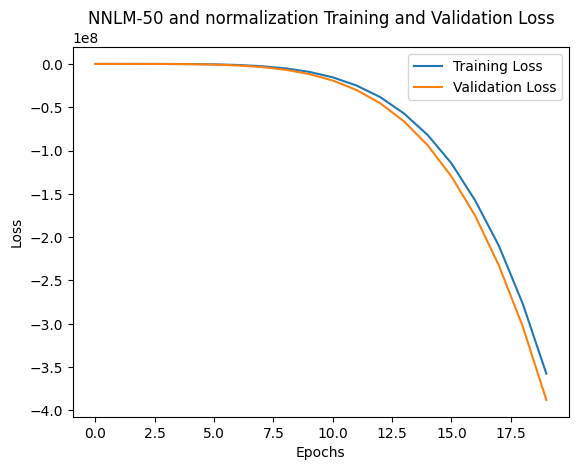

In [74]:
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('NNLM-50 and normalization Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()